一、Pytorch基本操作考察

1. 使用 𝐓𝐞𝐧𝐬𝐨𝐫 初始化一个 𝟏 × 𝟑 的矩阵 𝑴 和一个𝟐 × 𝟏 的矩阵 𝑵，对两矩阵进行减法操作（要求实现三种不同的形式），给出结果并分析三种方式的不同（如果出现报错，分析报错的因），同时需要指出在计算过程中发生了什么

In [272]:
import torch

In [273]:
m = torch.Tensor([[1,2,3]])
n = torch.Tensor([[5],[6]])

In [274]:
print(m - n)

tensor([[-4., -3., -2.],
        [-5., -4., -3.]])


Broadcasting能够实现Tensor自动维度增加（unsqueeze）与维度扩展（expand），以使两个Tensor的shape一致，如果 x 和 y 的维度不同，那么对于维度较小的 tensor 的维度补 1，使它们维度相同。
然后，对于每个维度，计算结果的维度值就是 x 和 y 中较大的那个值。
因此相减结果的维度应该是[2,3]，m被扩充成[[1,2,3],[1,2,3]]，n被扩充成[[5,5,5],[6,6,6]]

In [275]:
print(m.shape)
print(n.shape)
print((m-n).shape)


torch.Size([1, 3])
torch.Size([2, 1])
torch.Size([2, 3])


In [276]:
print(torch.sub(m, n))

tensor([[-4., -3., -2.],
        [-5., -4., -3.]])


In [277]:
print(m)

tensor([[1., 2., 3.]])


torch.sub()和减法的效果一致，且被减数不变

In [278]:
m.sub_(n)
print(m)

RuntimeError: output with shape [1, 3] doesn't match the broadcast shape [2, 3]

torch.sub_()功能与torch.sub()相同，区别在与torch.sub_()是torch.sub()的in-place操作版本。
in-place 操作是直接改变给定线性代数、向量、矩阵(张量)的内容而不需要复制的运算。
减法操作的结果的形状是[2,3]，而被减数m的形状是[1,3]，两个形状不一样所以报错了。无法赋值一个形状为[2,3]的数给m。

2. ① 利用 𝐓𝐞𝐧𝐬𝐨𝐫 创建两个大小分别 𝟑 × 𝟐 和 𝟒 × 𝟐 的随机数矩阵 𝑷 和 𝑸 ，要求服从均值为0，标准差0.01为的正态分布；② 对第二步得到的矩阵 𝑸 进行形状变换得到 𝑸 的转置 𝑸𝑻 ；③ 对上述得到的矩阵 𝑷 和矩阵 𝑸𝑻 求矩阵相乘

In [ ]:
p = torch.Tensor(3,2)
q = torch.Tensor(4,2)
torch.nn.init.normal_(p,mean=0, std=0.01)
torch.nn.init.normal_(q,mean=0, std=0.01)
print(p)
print(q)

tensor([[ 0.0066,  0.0102],
        [-0.0073, -0.0031],
        [-0.0065, -0.0011]])
tensor([[ 0.0084,  0.0104],
        [ 0.0025, -0.0048],
        [ 0.0063,  0.0234],
        [ 0.0151,  0.0079]])


In [ ]:
torch.transpose(q,dim0=0,dim1=1)
torch.mm(p,q)

tensor([[ 1.6117e-04, -3.1666e-05,  2.7953e-04,  1.8049e-04],
        [-9.3779e-05, -3.9214e-06, -1.1848e-04, -1.3533e-04],
        [-6.5489e-05, -1.1341e-05, -6.5738e-05, -1.0617e-04]])

3. 给定公式 $𝑦_3 = 𝑦_1 + 𝑦_2 = 𝑥^2 + 𝑥^3$，且 𝑥 = 1。利用学习所得到的Tensor的相关知识，求𝑦3对𝑥的梯度，即$\frac{d y_{3}}{d x}$。
要求在计算过程中，在计算 𝑥3 时中断梯度的追踪，观察结果并进行原因分析提示, 可使用 with torch.no_grad()， 举例:
with torch.no_grad():
y = x * 5

In [ ]:
x = torch.tensor([1.0],requires_grad=True)
y1 = x * x
y2 = x * x * x
print(y2.requires_grad)
y3 = y1 + y2
y3.backward()
print(x.grad)

True
tensor([5.])


不中断梯度跟踪，$\frac{d y_{3}}{d x}=2x+3x=5x$，当x=1时，计算结果为5

In [ ]:
x = torch.tensor([1.0],requires_grad=True)
y1 = x * x
y2 = x * x * x
print(y2.requires_grad)
with torch.no_grad():
    y2 = x * x * x
    print(y2.requires_grad)
    print(y2.grad_fn)
y3 = y1 + y2
y3.backward()
print(x.grad)

True
False
None
tensor([2.])


In [ ]:
x = torch.tensor([1.0],requires_grad=True)
y1 = x * x
y2 = x * x * x
print(y2.requires_grad)
with torch.no_grad():
    y2 = x * 5
    print(y2.requires_grad)
    print(y2.grad_fn)
y3 = y1 + y2
y3.backward()
print(x.grad)

True
False
None
tensor([2.])


因为y2中断了梯度的跟踪，所以无论y2值怎么算，梯度只返回$x^2$的梯度计算结果，即：2x，当x=1时结果为2

二、动手实现 logistic 回归

1. 要求动手从0实现 logistic 回归（只借助Tensor和Numpy相关的库）在人工构造的数据集上进行训练和测试，并从loss以及训练集上的准确率等多个角度对结果进行分析
（可借助nn.BCELoss或nn.BCEWithLogitsLoss作为损失函数，从零实现二元交叉熵为选作）

In [306]:
import numpy as np
%matplotlib inline
from matplotlib.colors import ListedColormap
import torch
import matplotlib.pyplot as plt

In [307]:
n_data = torch.ones(100, 2) # 数据的基本形态
x1 = torch.normal(2 * n_data, 1) # shape=(100, 2)
y1 = torch.zeros(100) # 类型0 shape=(100, 1)
x2 = torch.normal(-2 * n_data, 1) # shape=(100, 2)
y2 = torch.ones(100) # 类型1 shape=(100, 1)
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)
x = torch.cat((x1, x2), 0).type(torch.FloatTensor)
y = torch.cat((y1, y2), 0).type(torch.FloatTensor)

In [308]:
index = 80
train_x = torch.cat((x1[:index], x2[:index]), 0).type(torch.FloatTensor)
train_y = torch.cat((y1[:index], y2[:index]), 0).type(torch.FloatTensor)
test_x = torch.cat((x1[index:], x2[index:]), 0).type(torch.FloatTensor)
test_y = torch.cat((y1[index:], y2[index:]), 0).type(torch.FloatTensor)
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

torch.Size([160, 2]) torch.Size([160]) torch.Size([40, 2]) torch.Size([40])


In [309]:
def initialize(m):
    W=torch.tensor(np.random.normal(0,0.01,(m,1)),dtype=torch.float32)
    b=torch.zeros(1,dtype=torch.float32)
    W.requires_grad_(requires_grad=True)
    b.requires_grad_(requires_grad=True)

    return W, b

In [310]:
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        j=torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,j),labels.index_select(0,j)


In [311]:
def linear_combination(X, W, b):
    Z = torch.mm(X, W) + b 
    return Z

In [312]:
def my_sigmoid(x):
    activations = 1/(1 + torch.pow(np.e,-x))
    return activations

In [313]:
def forward(X, W, b):
    Z = linear_combination(X, W, b) 
    y_pred = my_sigmoid(Z) 
    return y_pred

In [314]:
def logloss(y_true, y_pred):
    y_true = y_true.view(y_pred.size())  
    loss = -y_true.mul(torch.log(y_pred))-(1-y_true).mul(torch.log(1-y_pred))
    return loss

In [315]:
def update(params, batch_size, learning_rate):
    for param in params:
        param.data -= learning_rate * param.grad / batch_size

In [316]:
def evaluate_accuracy(test_x, test_y, W, b, batch_size):  
    acc_sum,n,test_l_sum = 0.0,0 ,0 
    for testX,testY in data_iter(batch_size, test_x, test_y): 
        test_y_pred = forward(testX, W, b) 
        test_y_pred = torch.squeeze(torch.where(test_y_pred>0.5,torch.tensor(1.0),torch.tensor(0.0)))  
        acc_sum += (test_y_pred==testY).float().sum().item()
        training_loss = logloss(testY, test_y_pred).sum()
        test_l_sum += training_loss.item()  
        n += testY.shape[0]  
    return acc_sum/n,test_l_sum/n 


In [317]:
def train(test_acc, train_acc, train_loss, test_loss, W, b, epochs, batch_size, learning_rate, train_x,train_y,test_x, test_y):
    training_loss_list = []
    for i in range(epochs):
        train_l_sum, train_acc_sum, n = 0.0,0.0,0  
        for trainX, trainY in data_iter(batch_size, train_x,train_y):
            train_y_pred = forward(trainX, W, b) 
            training_loss = logloss(trainY, train_y_pred).sum()
            training_loss.backward()
            update([W,b],batch_size,learning_rate)
            W.grad.data.zero_()   
            b.grad.data.zero_() 
            train_l_sum += training_loss.item()  
            train_y_pred = torch.squeeze(torch.where(train_y_pred>0.5,torch.tensor(1.0),torch.tensor(0.0)))  
            train_acc_sum += (train_y_pred==trainY).sum().item()  
            n += trainY.shape[0] 
        test_a,test_l = evaluate_accuracy(test_x, test_y, W,b,batch_size)
        test_acc.append(test_a)
        test_loss.append(test_l)
        train_acc.append(train_acc_sum/n)
        train_loss.append(train_l_sum/n)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
            % (i + 1, train_loss[i], train_acc[i], test_acc[i]))


In [318]:
def plot_loss_curve(*args,xlabel = "epoch",ylabel = "loss"):
    for i in args:
        x = np.linspace(0,len(i[0]),len(i[0]))  
        plt.plot(x,i[0],label=i[1],linewidth=1.5)  
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

epoch 1, loss 0.6856, train acc 1.000, test acc 1.000
epoch 2, loss 0.6821, train acc 1.000, test acc 1.000
epoch 3, loss 0.6786, train acc 1.000, test acc 1.000
epoch 4, loss 0.6752, train acc 1.000, test acc 1.000
epoch 5, loss 0.6718, train acc 1.000, test acc 1.000
epoch 6, loss 0.6684, train acc 1.000, test acc 1.000
epoch 7, loss 0.6650, train acc 1.000, test acc 1.000
epoch 8, loss 0.6617, train acc 1.000, test acc 1.000
epoch 9, loss 0.6584, train acc 1.000, test acc 1.000
epoch 10, loss 0.6551, train acc 1.000, test acc 1.000
epoch 11, loss 0.6518, train acc 1.000, test acc 1.000
epoch 12, loss 0.6486, train acc 1.000, test acc 1.000
epoch 13, loss 0.6454, train acc 1.000, test acc 1.000
epoch 14, loss 0.6422, train acc 1.000, test acc 1.000
epoch 15, loss 0.6390, train acc 1.000, test acc 1.000
epoch 16, loss 0.6359, train acc 1.000, test acc 1.000
epoch 17, loss 0.6328, train acc 1.000, test acc 1.000
epoch 18, loss 0.6297, train acc 1.000, test acc 1.000
epoch 19, loss 0.62

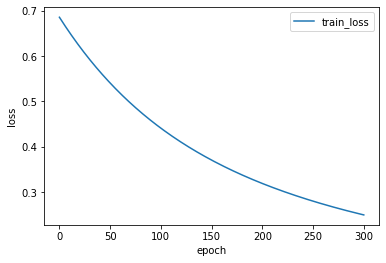

In [319]:
lr = 0.0005  
num_epochs = 300
batch_size = 50
test_acc,train_acc= [],[]
train_loss,test_loss =[],[] 
W, b = initialize(2)

train(test_acc,train_acc,train_loss,test_loss,W, b,num_epochs,batch_size,lr,train_x,train_y,test_x, test_y)

plot_loss_curve([train_loss,"train_loss"])

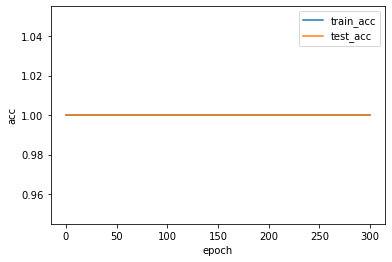

In [320]:
plot_loss_curve([train_acc,"train_acc"],[test_acc,"test_acc"],ylabel = "acc")

2. 利用 torch.nn 实现 logistic 回归在人工构造的数据集上进行训练和测试，并对结果进行分析，并从loss以及训练集上的准确率等多个角度对结果进行分析

In [333]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torch.nn import init
from torch import nn
batch_size = 50  
dataset = Data.TensorDataset(train_x, train_y)  
train_data_iter = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)  
dataset = Data.TensorDataset(test_x, test_y)  
test_data_iter = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)  


In [334]:
class Logistic(nn.Module):  
    def __init__(self,n_features):  
        super(Logistic, self).__init__()  
        self.learning_rate = nn.Linear(n_features, 1)  
        self.activation_function = nn.Sigmoid()  
    
    def forward(self, x): 
        x = self.learning_rate(x)  
        x = self.activation_function(x)  
        return x  


In [335]:
logistic_model = Logistic(2) 
loss = nn.BCELoss()  
optimizer = torch.optim.SGD(logistic_model.parameters(), lr=1e-3)  
init.normal_(logistic_model.learning_rate.weight, mean=0, std=0.01)  
init.constant_(logistic_model.learning_rate.bias, val=0) 
print(logistic_model.learning_rate.weight)  
print(logistic_model.learning_rate.bias)  

Parameter containing:
tensor([[-0.0079, -0.0092]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [336]:
def evaluate_accuracy():  
    acc_sum,n,test_l_sum = 0.0,0 ,0 
    for testX,testY in train_data_iter: 
        test_y_pred = logistic_model(testX) 
        training_loss = loss(test_y_pred, testY.view(-1, 1))  
        test_y_pred = torch.squeeze(torch.where(test_y_pred>0.5,torch.tensor(1.0),torch.tensor(0.0)))  
        acc_sum += (test_y_pred==testY).float().sum().item()
        test_l_sum += training_loss.item()  
        n += testY.shape[0]  
    return acc_sum/n,test_l_sum/n 


In [337]:
def train(test_acc, train_acc, train_loss, test_loss,epochs):
    for i in range(epochs):
        train_l_sum, train_acc_sum, n = 0.0,0.0,0  
        for trainX, trainY in train_data_iter:
            train_y_pred = logistic_model(trainX) 
            l = loss(train_y_pred, trainY.view(-1, 1))  
            optimizer.zero_grad()
            l.backward()  
            # update model parameters  
            optimizer.step()  
            #计算每个epoch的loss  
            train_l_sum += l.item()  
            #计算训练样本的准确率  
            train_y_pred = torch.squeeze(torch.where(train_y_pred>0.5,torch.tensor(1.0),torch.tensor(0.0)))  
            train_acc_sum += (train_y_pred==trainY).sum().item()  
            n += trainY.shape[0]
        test_a,test_l = evaluate_accuracy()
        test_acc.append(test_a)
        test_loss.append(test_l)
        train_acc.append(train_acc_sum/n)
        train_loss.append(train_l_sum/n)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
            % (i + 1, train_loss[i], train_acc[i], test_acc[i]))


epoch 1, loss 0.0168, train acc 1.000, test acc 1.000
epoch 2, loss 0.0166, train acc 1.000, test acc 1.000
epoch 3, loss 0.0164, train acc 1.000, test acc 1.000
epoch 4, loss 0.0161, train acc 1.000, test acc 1.000
epoch 5, loss 0.0160, train acc 1.000, test acc 1.000
epoch 6, loss 0.0158, train acc 1.000, test acc 1.000
epoch 7, loss 0.0157, train acc 1.000, test acc 1.000
epoch 8, loss 0.0154, train acc 1.000, test acc 1.000
epoch 9, loss 0.0152, train acc 1.000, test acc 1.000
epoch 10, loss 0.0150, train acc 1.000, test acc 1.000
epoch 11, loss 0.0149, train acc 1.000, test acc 1.000
epoch 12, loss 0.0147, train acc 1.000, test acc 1.000
epoch 13, loss 0.0146, train acc 1.000, test acc 1.000
epoch 14, loss 0.0144, train acc 1.000, test acc 1.000
epoch 15, loss 0.0141, train acc 1.000, test acc 1.000
epoch 16, loss 0.0140, train acc 1.000, test acc 1.000
epoch 17, loss 0.0137, train acc 1.000, test acc 1.000
epoch 18, loss 0.0138, train acc 1.000, test acc 1.000
epoch 19, loss 0.01

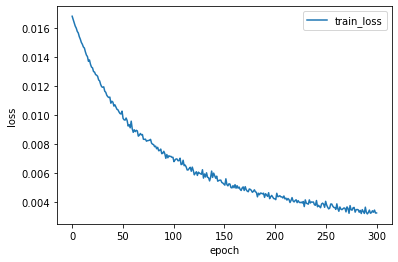

In [338]:
lr = 0.0005  
num_epochs = 300
batch_size = 50
test_acc,train_acc= [],[]
train_loss,test_loss =[],[] 
W, b = initialize(2)

train(test_acc,train_acc,train_loss,test_loss,num_epochs)

plot_loss_curve([train_loss,"train_loss"])

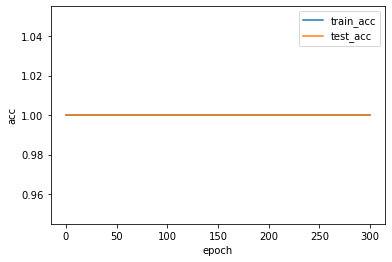

In [339]:
plot_loss_curve([train_acc,"train_acc"],[test_acc,"test_acc"],ylabel = "acc")

三、动手实现 softmax 回归

1. 要求动手从0实现 softmax 回归（只借助Tensor和Numpy相关的库）在Fashion-MNIST数据集上进行训练和测试，并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析（要求从零实现交叉熵损失函数）

In [363]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torch.nn import init
from torch import nn
from torchvision import transforms as transforms
import torchvision
from torch.utils.data import DataLoader

batch_size = 256
mnist_train = torchvision.datasets.FashionMNIST(root='../Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='../Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=0)


In [364]:
def cross_entropy(y_true, y_pred):
    return - torch.log(y_pred.gather(1,y_true.view(-1,1)))

def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size 

In [365]:
def initialize(m, n):
    num_inputs = m
    num_outputs = n
    W = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_outputs)),dtype=torch.float) 
    b = torch.zeros(num_outputs,dtype=torch.float) 
    W.requires_grad_(requires_grad=True)
    b.requires_grad_(requires_grad=True)

    return W, b

In [366]:
def softmax(X):
    X_exp = X.exp() 
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition 

In [367]:
def linear_combination(X, W, b, m):
    Z = torch.mm(X.view((-1,m)), W) + b 
    return Z

In [368]:
def forward(X, W, b, m):
    Z = linear_combination(X, W, b, m) 
    y_pred = softmax(Z) 
    return y_pred

In [383]:
def evaluate_accuracy(data_iter, m, W, b):  
    acc_sum,n,test_l_sum = 0.0,0 ,0 
    for testX, testY in data_iter: 
        acc_sum += (forward(testX, W, b, m).argmax(dim = 1) == testY).float().sum().item()
        l = cross_entropy(testY,forward(testX, W, b, m)).sum()
        test_l_sum += l.item()  
        n += testY.shape[0]  
    return acc_sum/n,test_l_sum/n 


In [384]:
def train(test_acc, train_acc, train_loss, test_loss, W, b, epochs, batch_size, learning_rate ,data_iter, m):
    for i in range(epochs):
        train_l_sum, train_acc_sum, n = 0.0,0.0,0  
        for trainX, trainY in train_iter:
            train_y_pred = forward(trainX, W, b, m) 
            training_loss = cross_entropy(trainY, train_y_pred).sum()
            training_loss.backward()
            update([W,b],batch_size,learning_rate)
            W.grad.data.zero_()   
            b.grad.data.zero_() 
            train_l_sum += training_loss.item()  
            train_acc_sum += (train_y_pred.argmax(dim=1)==trainY).sum().item()  
            n += trainY.shape[0] 
        test_a,test_l = evaluate_accuracy(test_iter, m, W, b)
        test_acc.append(test_a)
        test_loss.append(test_l)
        train_acc.append(train_acc_sum/n)
        train_loss.append(train_l_sum/n)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
            % (i + 1, train_loss[i], train_acc[i], test_acc[i]))


epoch 1, loss 2.1734, train acc 0.317, test acc 0.495
epoch 2, loss 1.9692, train acc 0.585, test acc 0.625
epoch 3, loss 1.8132, train acc 0.644, test acc 0.642
epoch 4, loss 1.6877, train acc 0.655, test acc 0.648
epoch 5, loss 1.5853, train acc 0.659, test acc 0.653
epoch 6, loss 1.5006, train acc 0.662, test acc 0.655
epoch 7, loss 1.4297, train acc 0.663, test acc 0.656
epoch 8, loss 1.3697, train acc 0.665, test acc 0.657
epoch 9, loss 1.3183, train acc 0.666, test acc 0.659
epoch 10, loss 1.2738, train acc 0.668, test acc 0.660
epoch 11, loss 1.2349, train acc 0.669, test acc 0.662
epoch 12, loss 1.2006, train acc 0.671, test acc 0.664
epoch 13, loss 1.1702, train acc 0.673, test acc 0.666
epoch 14, loss 1.1429, train acc 0.676, test acc 0.668
epoch 15, loss 1.1184, train acc 0.678, test acc 0.670
epoch 16, loss 1.0961, train acc 0.681, test acc 0.673
epoch 17, loss 1.0759, train acc 0.684, test acc 0.674
epoch 18, loss 1.0573, train acc 0.686, test acc 0.676
epoch 19, loss 1.04

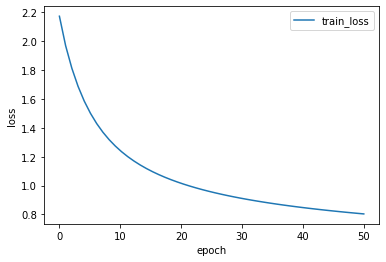

In [385]:
lr = 0.0005  
num_epochs = 50
batch_size = 256
test_acc,train_acc= [],[]
train_loss,test_loss =[],[] 
W, b = initialize(784, 10)

train(test_acc,train_acc,train_loss,test_loss,W, b,num_epochs,batch_size,lr,data_iter, 784)

plot_loss_curve([train_loss,"train_loss"])

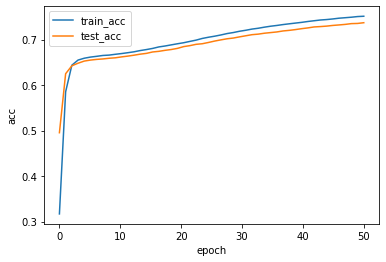

In [386]:
plot_loss_curve([train_acc,"train_acc"],[test_acc,"test_acc"],ylabel = "acc")

2. 利用torch.nn实现 softmax 回归在Fashion-MNIST数据集上进行训练和测试，并从loss，训练集以及测试集上的准确率等多个角度对结果进行分析

In [400]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torch.nn import init
from torch import nn
from torchvision import transforms as transforms
import torchvision
from torch.utils.data import DataLoader


In [401]:
forward = torch.nn.Sequential(nn.Flatten(), nn.Linear(784,10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std = 0.01)
forward.apply(init_weights)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(forward.parameters(),lr = 0.1)

In [402]:
def evaluate_accuracy(data_iter):  
    acc_sum,n,test_l_sum = 0.0,0 ,0 
    for testX, testY in data_iter: 
        acc_sum += (forward(testX).argmax(dim = 1) == testY).float().sum().item()
        l = loss(forward(testX),testY).sum()
        test_l_sum += l.item()  
        n += testY.shape[0]  
    return acc_sum/n,test_l_sum/n 

In [403]:
def train(test_acc, train_acc, train_loss, test_loss, epochs):
    for i in range(epochs):
        train_l_sum, train_acc_sum, n = 0.0,0.0,0  
        for trainX, trainY in train_iter:
            train_y_pred = forward(trainX) 
            training_loss = loss(train_y_pred, trainY).sum()
            optimizer.zero_grad()
            training_loss.backward()
            optimizer.step()
            train_l_sum += training_loss.item()  
            train_acc_sum += (train_y_pred.argmax(dim=1)==trainY).sum().item()  
            n += trainY.shape[0] 
        test_a,test_l = evaluate_accuracy(test_iter)
        test_acc.append(test_a)
        test_loss.append(test_l)
        train_acc.append(train_acc_sum/n)
        train_loss.append(train_l_sum/n)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
            % (i + 1, train_loss[i], train_acc[i], test_acc[i]))


epoch 1, loss 0.0031, train acc 0.750, test acc 0.742
epoch 2, loss 0.0022, train acc 0.813, test acc 0.811
epoch 3, loss 0.0021, train acc 0.826, test acc 0.809
epoch 4, loss 0.0020, train acc 0.833, test acc 0.819
epoch 5, loss 0.0019, train acc 0.836, test acc 0.819
epoch 6, loss 0.0019, train acc 0.840, test acc 0.826
epoch 7, loss 0.0018, train acc 0.843, test acc 0.823
epoch 8, loss 0.0018, train acc 0.845, test acc 0.832
epoch 9, loss 0.0018, train acc 0.847, test acc 0.834
epoch 10, loss 0.0017, train acc 0.849, test acc 0.829
epoch 11, loss 0.0017, train acc 0.849, test acc 0.830
epoch 12, loss 0.0017, train acc 0.850, test acc 0.817
epoch 13, loss 0.0017, train acc 0.852, test acc 0.837
epoch 14, loss 0.0017, train acc 0.853, test acc 0.830
epoch 15, loss 0.0017, train acc 0.852, test acc 0.832
epoch 16, loss 0.0017, train acc 0.853, test acc 0.834
epoch 17, loss 0.0017, train acc 0.854, test acc 0.835
epoch 18, loss 0.0017, train acc 0.855, test acc 0.838
epoch 19, loss 0.00

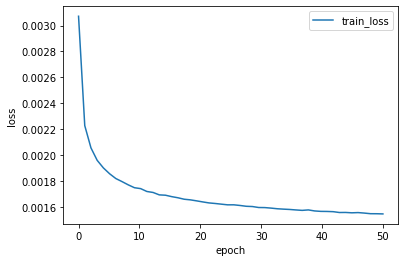

In [404]:
lr = 0.0005  
num_epochs = 50
batch_size = 256
test_acc,train_acc= [],[]
train_loss,test_loss =[],[] 
W, b = initialize(784, 10)

train(test_acc,train_acc,train_loss,test_loss,num_epochs)

plot_loss_curve([train_loss,"train_loss"])

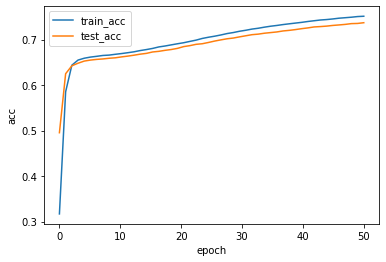

In [390]:
plot_loss_curve([train_acc,"train_acc"],[test_acc,"test_acc"],ylabel = "acc")